# Tidy data

Tidy data is:

1. Each variable forms a column
2. Each observation forms a row
3. Each type of observational unit forms a table

## Imports

In [1]:
%matplotlib inline

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.options.display.max_rows = 10
sns.set(style='ticks', context='talk')

## Data

<div class="alert alert-block alert-info">
    <b>Techniques of note</b>
    <br><br>
    <li><b><code>.read_html</code></b> to read html tables.</li>
    <li><b><code>.dropna</code></b> is well known, but good to know that it has a `thresh` argument that let's you set how many items should be missing per row.</li>
    <li><b><code>.read_html</code></b> to read html tables.</li>
    <li><b><code>.assign</code></b> can take callable (<code>lambda</code>)</li>
    <li><b><code>.set_index</code></b> has an <code>append</code> keyword to add new index to existing one</li>
    <li><b><code>.rename_axis</code></b> can just take in a list of names</li>
</div>

In [60]:
fp = "data/nba.csv"

if not os.path.exists(fp):
    tables = pd.read_html(
        "http://www.basketball-reference.com/leagues/NBA_2016_games.html"
    )
    games = tables[0]
    games.to_csv(fp)
else:
    games = pd.read_csv(fp)
games.head()

,Unnamed: 0,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,Unnamed: 6,Unnamed: 7,Attend.,Notes
0,0,"Tue, Oct 27, 2015",8:00p,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,21957,NaN
1,1,"Tue, Oct 27, 2015",8:00p,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,19187,NaN
2,2,"Tue, Oct 27, 2015",10:30p,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,19596,NaN
3,3,"Wed, Oct 28, 2015",7:00p,Washington Wizards,88,Orlando Magic,87,Box Score,NaN,18846,NaN
4,4,"Wed, Oct 28, 2015",7:30p,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,18624,NaN


Clean data

In [9]:
column_names = {
    "Date": "date",
    "Start (ET)": "start",
    "Unamed: 2": "box",
    "Visitor/Neutral": "away_team",
    "PTS": "away_points",
    "Home/Neutral": "home_team",
    "PTS.1": "home_points",
    "Unamed: 7": "n_ot",
}
games = (
    games.rename(columns=column_names)
    .dropna(thresh=4)[["date", "away_team", "away_points", "home_team", "home_points"]]
    .assign(date=lambda x: pd.to_datetime(x["date"], format="%a, %b %d, %Y"))
    .set_index("date", append=True)
    .rename_axis(["game_id", "date"])
    .sort_index()
)
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97
1,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111
3,2015-10-28,Washington Wizards,88,Orlando Magic,87
4,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112


## Make tidy

<div class="alert alert-block alert-info">
    <b>Techniques of note</b>
    <br><br>
    <li><b><code>pd.melt</code></b> to unpivot table (wide to long)</li>
    <li><b><code>.diff</code></b> to find difference between this column and last one. Can use with <code>.groupby</code></li>
    <li><b><code>pd.pivot_table</code></b> to pivot DataFrame (long to wide)</li>
</div>

**How many days of rest did each team get in between each game?**

In [10]:
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97
1,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111
3,2015-10-28,Washington Wizards,88,Orlando Magic,87
4,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112


In [11]:
tidy = pd.melt(
    games.reset_index(),
    id_vars=["game_id", "date"],
    value_vars=["away_team", "home_team"],
    value_name="team",
)
tidy.head()

,game_id,date,variable,team
0,0,2015-10-27,away_team,Cleveland Cavaliers
1,1,2015-10-27,away_team,Detroit Pistons
2,2,2015-10-27,away_team,New Orleans Pelicans
3,3,2015-10-28,away_team,Washington Wizards
4,4,2015-10-28,away_team,Philadelphia 76ers


Now get number of days between games

In [12]:
tidy["rest"] = tidy.sort_values("date").groupby("team")["date"].diff().dt.days - 1
tidy.dropna().head()

,game_id,date,variable,team,rest
5,5,2015-10-28,away_team,Chicago Bulls,0.0
11,11,2015-10-28,away_team,Cleveland Cavaliers,0.0
14,14,2015-10-28,away_team,New Orleans Pelicans,0.0
17,17,2015-10-29,away_team,Memphis Grizzlies,0.0
18,18,2015-10-29,away_team,Atlanta Hawks,1.0


Return to pivoted table

In [13]:
by_game = pd.pivot_table(
    tidy, values="rest", index=["game_id", "date"], columns="variable"
).rename(columns={"away_team": "away_rest", "home_team": "home_rest"})
df = pd.concat([games, by_game], axis=1)
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest
game_id,date,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0
18,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0
19,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0
20,2015-10-30,Miami Heat,92,Cleveland Cavaliers,102,1.0,1.0
21,2015-10-30,Utah Jazz,99,Philadelphia 76ers,71,1.0,1.0


**What was each team's average days of rest, at home and on the road?**

In [14]:
tidy.head()

,game_id,date,variable,team,rest
0,0,2015-10-27,away_team,Cleveland Cavaliers,NaN
1,1,2015-10-27,away_team,Detroit Pistons,NaN
2,2,2015-10-27,away_team,New Orleans Pelicans,NaN
3,3,2015-10-28,away_team,Washington Wizards,NaN
4,4,2015-10-28,away_team,Philadelphia 76ers,NaN


/Users/pcosta/Library/Caches/pypoetry/virtualenvs/modern-pandas-gheCaqJK-py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/pcosta/Library/Caches/pypoetry/virtualenvs/modern-pandas-gheCaqJK-py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the barplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


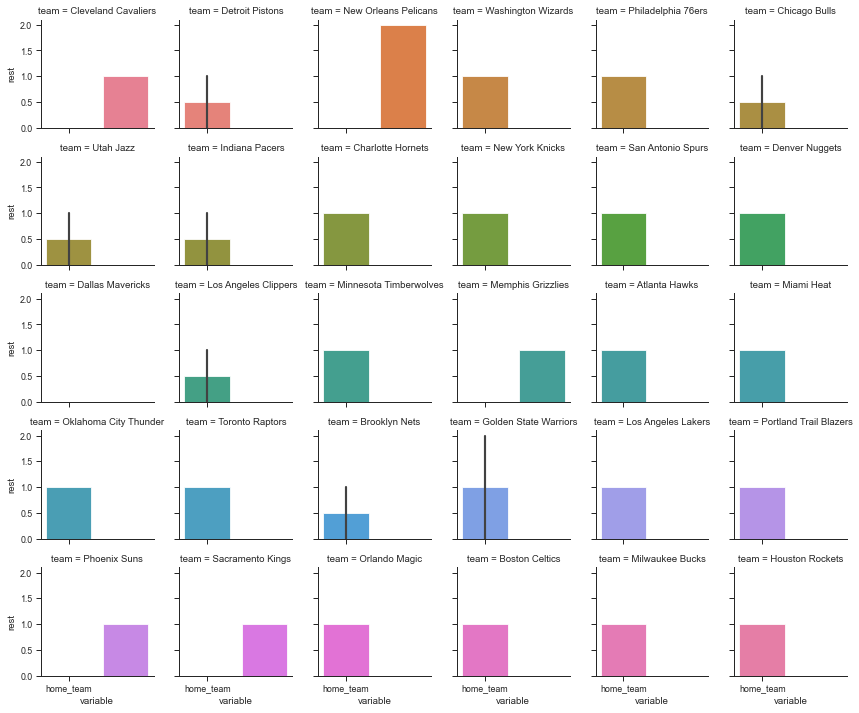

In [15]:
sns.set(style="ticks", context="paper")
g = sns.FacetGrid(tidy, col="team", col_wrap=6, hue="team", size=2)
g.map(sns.barplot, "variable", "rest");

**Distribution of rest differences in games**

In [16]:
df["home_win"] = df["home_points"] > df["away_points"]
df["rest_spread"] = df["home_rest"] - df["away_rest"]
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0,False,0.0
18,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0,False,-1.0
19,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0,True,0.0
20,2015-10-30,Miami Heat,92,Cleveland Cavaliers,102,1.0,1.0,True,0.0
21,2015-10-30,Utah Jazz,99,Philadelphia 76ers,71,1.0,1.0,False,0.0


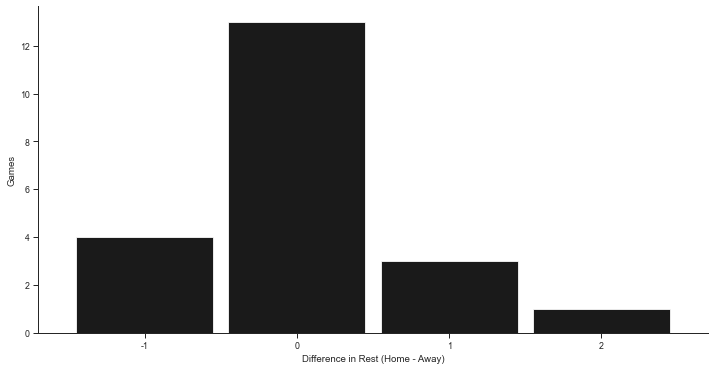

In [17]:
delta = (by_game.home_rest - by_game.away_rest).dropna().astype(int)
ax = (
    delta.value_counts()
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0)
    .sort_index()
    .plot(kind="bar", color="k", width=0.9, rot=0, figsize=(12, 6))
)
sns.despine()
ax.set(xlabel="Difference in Rest (Home - Away)", ylabel="Games");

Win percentage by rest difference

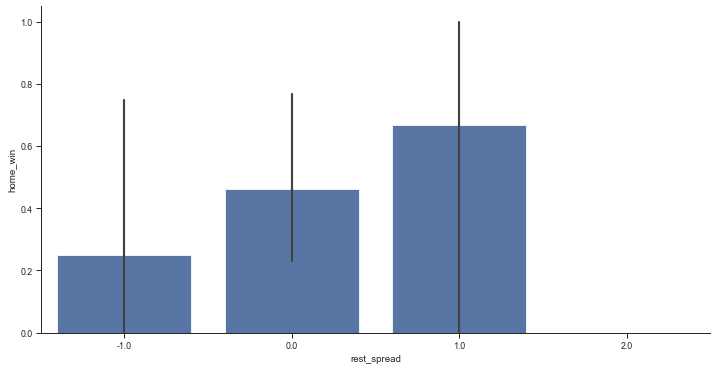

In [18]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(
    x="rest_spread",
    y="home_win",
    data=df.query("-3 <= rest_spread <= 3"),
    color="#4c72b0",
    ax=ax,
)
sns.despine()

## Stack / Unstack

<div class="alert alert-block alert-info">
    <b>Techniques of note</b>
    <br><br>
    <li><b><code>.stack</code></b> convert from wide to long format</li>
    <li><b><code>.unstack</code></b> convert from long to wide format</li>
</div>

In [19]:
rest = tidy.groupby(["date", "variable"]).rest.mean().dropna()
rest.head()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
Name: rest, dtype: float64

`rest` is now in "long" form.

In [20]:
rest.unstack().head()

variable,away_team,home_team
date,,
2015-10-28,0.000000,0.000000
2015-10-29,0.333333,0.000000
2015-10-30,1.083333,0.916667
2015-10-31,0.166667,0.833333


In [21]:
rest.unstack().stack()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
            home_team    0.916667
2015-10-31  away_team    0.166667
            home_team    0.833333
dtype: float64

`DataFrame.plot()` expects wide-form data—one line per column

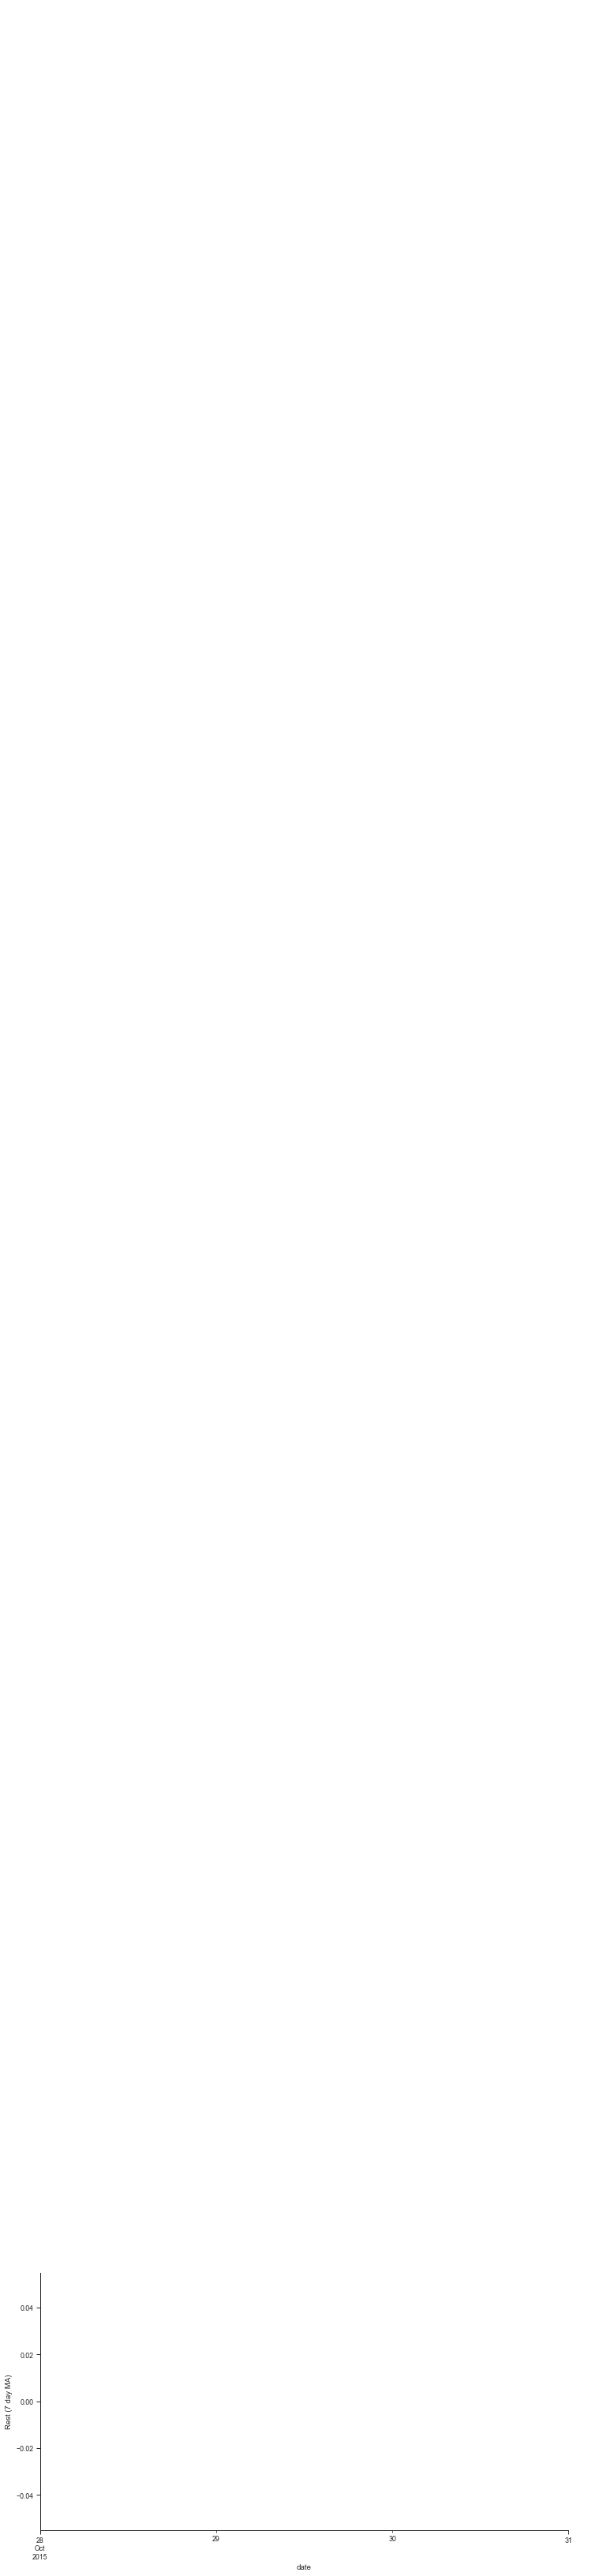

In [24]:
with sns.color_palette() as pal:
    b, g = pal.as_hex()[:2]

ax = (
    rest.unstack()
    .query("away_team < 7")
    .rolling(7)
    .mean()
    .plot(figsize=(12, 6), linewidth=3, legend=False)
)
ax.set(ylabel="Rest (7 day MA)")
ax.annotate("Home", (rest.index[-1][0], 1.02), color=g, size=14)
ax.annotate("Away", (rest.index[-1][0], 0.82), color=b, size=14)
sns.despine()

## Home court advantage

### 1. Create outcome variable

In [25]:
df["home_win"] = df.away_points < df.home_points

### 2. Find win % per team

In [27]:
df.head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,
0,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97,NaN,NaN,True,NaN
1,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94,NaN,NaN,False,NaN
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111,NaN,NaN,True,NaN
3,2015-10-28,Washington Wizards,88,Orlando Magic,87,NaN,NaN,False,NaN
4,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112,NaN,NaN,True,NaN


In [33]:
wins = (
    pd.melt(
        df.reset_index(),
        id_vars=["game_id", "date", "home_win"],
        value_name="team",
        var_name="is_home",
        value_vars=["home_team", "away_team"],
    )
    .assign(win=lambda x: x.home_win == (x.is_home == "home_team"))
    .groupby(["team", "is_home"])
    .win.agg(["sum", "count", "mean"])
    .rename(columns=dict(sum="n_wins", count="n_games", mean="win_pct"))
)
wins.head()

n_wins  n_games  win_pct
team           is_home                            
Atlanta Hawks  away_team     1.0        1      1.0
               home_team     1.0        2      0.5
Boston Celtics home_team     1.0        2      0.5
Brooklyn Nets  away_team     0.0        2      0.0
               home_team     0.0        1      0.0

/Users/pcosta/Library/Caches/pypoetry/virtualenvs/modern-pandas-gheCaqJK-py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/pcosta/Library/Caches/pypoetry/virtualenvs/modern-pandas-gheCaqJK-py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


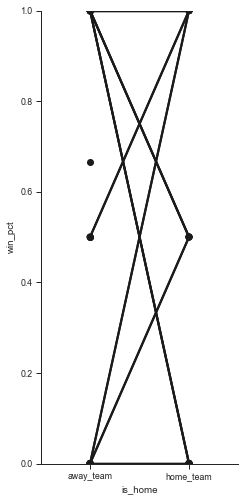

In [34]:
g = sns.FacetGrid(wins.reset_index(), hue="team", size=7, aspect=0.5, palette=["k"])
g.map(sns.pointplot, "is_home", "win_pct").set(ylim=(0, 1));

/Users/pcosta/Library/Caches/pypoetry/virtualenvs/modern-pandas-gheCaqJK-py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:243: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/Users/pcosta/Library/Caches/pypoetry/virtualenvs/modern-pandas-gheCaqJK-py3.8/lib/python3.8/site-packages/seaborn/axisgrid.py:728: UserWarning: Using the pointplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


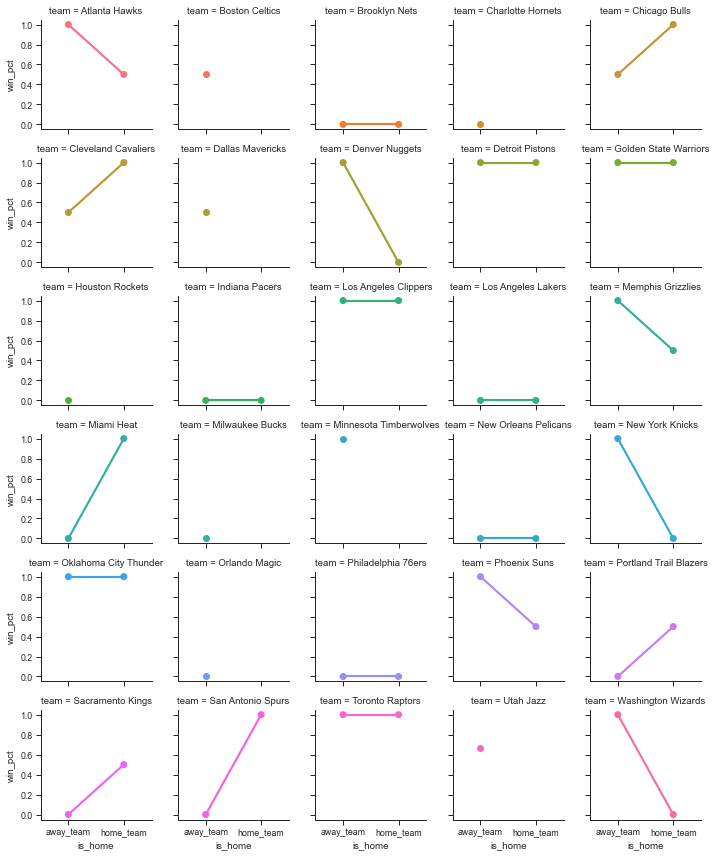

In [35]:
g = sns.FacetGrid(wins.reset_index(), col="team", hue="team", col_wrap=5, size=2)
g.map(sns.pointplot, "is_home", "win_pct")

In [36]:
win_percent = (
    # Use sum(games) / sum(games) instead of mean
    # since I don't know if teams play the same
    # number of games at home as away
    wins.groupby(level="team", as_index=True).apply(
        lambda x: x.n_wins.sum() / x.n_games.sum()
    )
)
win_percent.head()

team
Atlanta Hawks        0.666667
Boston Celtics       0.500000
Brooklyn Nets        0.000000
Charlotte Hornets    0.000000
Chicago Bulls        0.666667
dtype: float64

Text(0.5, 86.7, 'Win Percent')

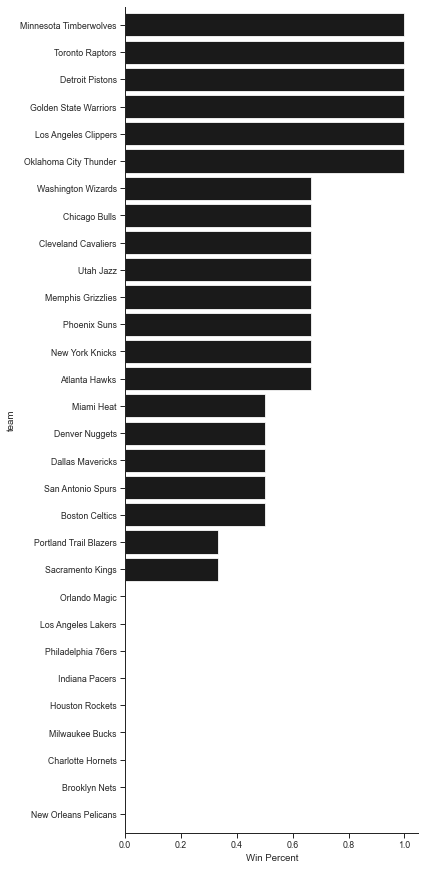

In [37]:
win_percent.sort_values().plot.barh(figsize=(6, 12), width=0.85, color="k")
plt.tight_layout()
sns.despine()
plt.xlabel("Win Percent")

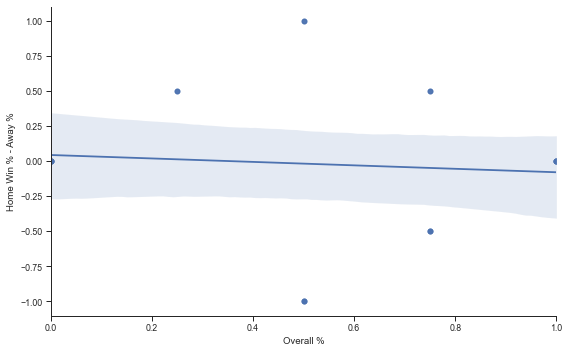

In [38]:
plt.figure(figsize=(8, 5))
(
    wins.win_pct.unstack()
    .assign(
        **{
            "Home Win % - Away %": lambda x: x.home_team - x.away_team,
            "Overall %": lambda x: (x.home_team + x.away_team) / 2,
        }
    )
    .pipe((sns.regplot, "data"), x="Overall %", y="Home Win % - Away %")
)
sns.despine()
plt.tight_layout()

In [39]:
df = df.assign(
    away_strength=df["away_team"].map(win_percent),
    home_strength=df["home_team"].map(win_percent),
    point_diff=df["home_points"] - df["away_points"],
    rest_diff=df["home_rest"] - df["away_rest"],
)
df.head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread,away_strength,home_strength,point_diff,rest_diff
game_id,date,,,,,,,,,,,,
0,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97,NaN,NaN,True,NaN,0.666667,0.666667,2,NaN
1,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94,NaN,NaN,False,NaN,1.000000,0.666667,-12,NaN
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111,NaN,NaN,True,NaN,0.000000,1.000000,16,NaN
3,2015-10-28,Washington Wizards,88,Orlando Magic,87,NaN,NaN,False,NaN,0.666667,0.000000,-1,NaN
4,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112,NaN,NaN,True,NaN,0.000000,0.500000,17,NaN
